# Seattle Airbnb Data Cleaning & Exploratory Analysis

This notebook explores and cleans a Seattle Airbnb listings dataset (downloaded from Kaggle) for SQL analysis and Tableau visualization.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [49]:
listings = pd.read_csv("/Users/courtney/Desktop/seattle-airbnb-analysis/data/raw/listings.csv")

#listings.shape
#listings.head()
#listings.info()
listings.columns
#listings


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

# To answer: What factors contribute to higher Airbnb prices in Seattle?

In [ ]:
# Cleaning the data: Here I disregard irrelevant columns to focus on price, location, room/property type, capacity, review information, and latitude/longitude

columns_to_keep = [
    "id",
    "neighbourhood_cleansed",
    "room_type",
    "property_type",
    "accommodates",
    "bedrooms",
    "bathrooms",
    "price",
    "number_of_reviews",
    "reviews_per_month",
    "review_scores_rating",
    "latitude",
    "longitude"

]

#The reduced dataframe

listings_clean = listings[columns_to_keep].copy()
listings_clean.head()
#listings_clean.shape



,id,neighbourhood_cleansed,room_type,property_type,accommodates,bedrooms,bathrooms,price,number_of_reviews,reviews_per_month,review_scores_rating,latitude,longitude
0,241032,West Queen Anne,Entire home/apt,Apartment,4,1.0,1.0,$85.00,207,4.07,95.0,47.636289,-122.371025
1,953595,West Queen Anne,Entire home/apt,Apartment,4,1.0,1.0,$150.00,43,1.48,96.0,47.639123,-122.365666
2,3308979,West Queen Anne,Entire home/apt,House,11,5.0,4.5,$975.00,20,1.15,97.0,47.629724,-122.369483
3,7421966,West Queen Anne,Entire home/apt,Apartment,3,0.0,1.0,$100.00,0,NaN,NaN,47.638473,-122.369279
4,278830,West Queen Anne,Entire home/apt,House,6,3.0,2.0,$450.00,38,0.89,92.0,47.632918,-122.372471


In [31]:
# Checking for missing values 

listings_clean.isna().sum()

# Will drop rows with missing values for bedrooms and bathrooms, as these will be important for pricing and the missing values make up a small percentage (<0.5%) of the data

# Will keep rows with missing review values ('reviews_per_month' and 'review_scores_rating'). It is likely that these missing reviews mean that the associated listing is still relatively new. If that is true, dropping these rows would bias the analysis toward older listings. 

# Will drop the one missing 'property_type' row.

id                          0
neighbourhood_cleansed      0
room_type                   0
property_type               1
accommodates                0
bedrooms                    6
bathrooms                  16
price                       0
number_of_reviews           0
reviews_per_month         627
review_scores_rating      647
latitude                    0
longitude                   0
dtype: int64

In [32]:
listings_clean.describe()

,id,accommodates,bedrooms,bathrooms,number_of_reviews,reviews_per_month,review_scores_rating,latitude,longitude
count,3.818000e+03,3818.000000,3812.000000,3802.000000,3818.000000,3191.000000,3171.000000,3818.000000,3818.000000
mean,5.550111e+06,3.349398,1.307712,1.259469,22.223415,2.078919,94.539262,47.628961,-122.333103
std,2.962660e+06,1.977599,0.883395,0.590369,37.730892,1.822348,6.606083,0.043052,0.031745
min,3.335000e+03,1.000000,0.000000,0.000000,0.000000,0.020000,20.000000,47.505088,-122.417219
25%,3.258256e+06,2.000000,1.000000,1.000000,2.000000,0.695000,93.000000,47.609418,-122.354320
50%,6.118244e+06,3.000000,1.000000,1.000000,9.000000,1.540000,96.000000,47.623601,-122.328874
75%,8.035127e+06,4.000000,2.000000,1.000000,26.000000,3.000000,99.000000,47.662694,-122.310800
max,1.034016e+07,16.000000,7.000000,8.000000,474.000000,12.150000,100.000000,47.733358,-122.240607


In [33]:
# Cleaning the data: drop rows with missing bedrooms, bathrooms, or property_type

listings_clean = listings_clean.dropna(
    subset=["bedrooms", "bathrooms", "property_type"]
)

listings_clean.isna().sum()

id                          0
neighbourhood_cleansed      0
room_type                   0
property_type               0
accommodates                0
bedrooms                    0
bathrooms                   0
price                       0
number_of_reviews           0
reviews_per_month         622
review_scores_rating      642
latitude                    0
longitude                   0
dtype: int64

# Price

In [34]:
# Summary statistics

listings_clean["price"].describe()

count        3795
unique        272
top       $150.00
freq          161
Name: price, dtype: object

In [35]:
# Remove dollar signs and commas to convert price to numeric
listings_clean["price"] = listings_clean["price"].str.replace("$", "", regex=False)
listings_clean["price"] = listings_clean["price"].str.replace(",", "", regex=False)
listings_clean["price"] = pd.to_numeric(listings_clean["price"], errors="coerce")


listings_clean["price"].head(10)
listings_clean["price"].dtype


dtype('float64')

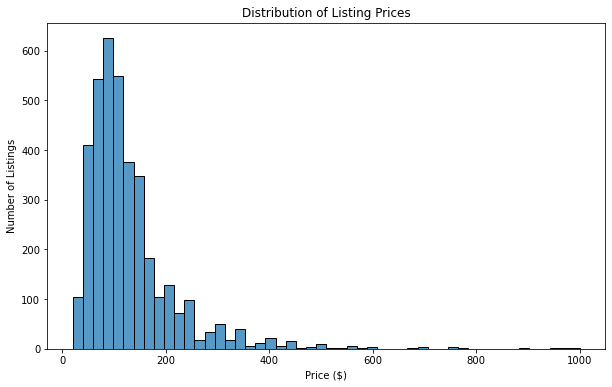

In [36]:
# Histogram (visualizing distribution)

plt.figure(figsize=(10,6))
sns.histplot(listings_clean["price"], bins=50, kde=False)
plt.title("Distribution of Listing Prices")
plt.xlabel("Price ($)")
plt.ylabel("Number of Listings")
plt.show()


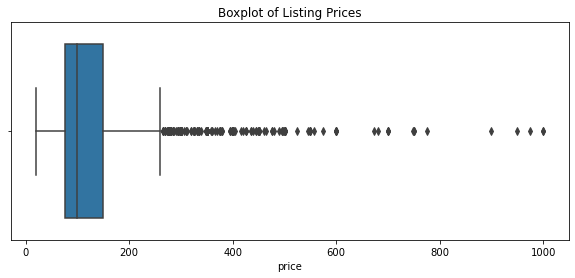

In [37]:
# Boxplot (checking for outliers)

plt.figure(figsize=(10,4))
sns.boxplot(x=listings_clean["price"])
plt.title("Boxplot of Listing Prices")
plt.show()


99th percentile price: 475.2999999999997
Original price summary:
count    3795.000000
mean      128.042688
std        90.433865
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

Capped price summary:
count    3795.000000
mean      126.449117
std        81.089049
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max       475.300000
Name: price_capped, dtype: float64


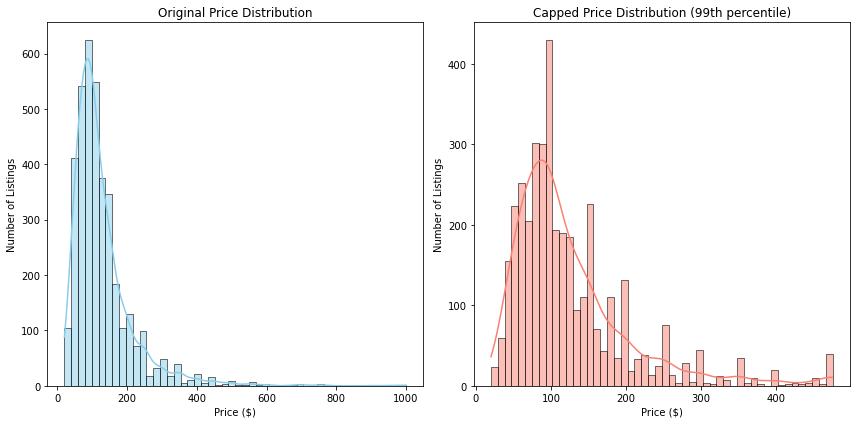

In [38]:
# Cap the top 1% of prices to prevent outliers from dominating later analysis

# Finding the 99th percentile of price
price_99 = listings_clean['price'].quantile(0.99)
print("99th percentile price:", price_99)

# Capping prices at the 99th percentile
listings_clean['price_capped'] = listings_clean['price'].clip(upper=price_99)

# Comparison of summary statistics before and after capping
print("Original price summary:")
print(listings_clean['price'].describe())
print("\nCapped price summary:")
print(listings_clean['price_capped'].describe())

# Histograms

plt.figure(figsize=(12,6))

# Original prices
plt.subplot(1,2,1)
sns.histplot(listings_clean['price'], bins=50, kde=True, color='skyblue')
plt.title("Original Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Number of Listings")

# Capped prices
plt.subplot(1,2,2)
sns.histplot(listings_clean['price_capped'], bins=50, kde=True, color='salmon')
plt.title("Capped Price Distribution (99th percentile)")
plt.xlabel("Price ($)")
plt.ylabel("Number of Listings")

plt.tight_layout()
plt.show()


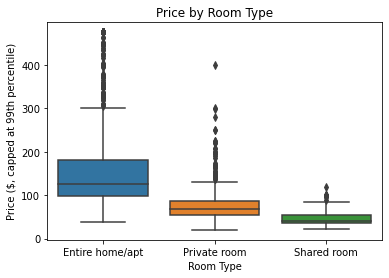

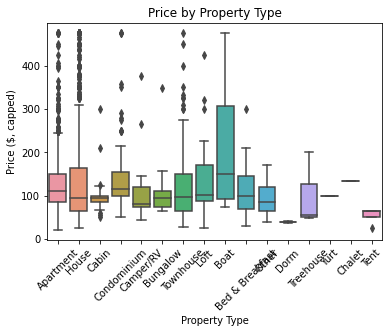

In [39]:
# Room type vs price
sns.boxplot(x='room_type', y='price_capped', data=listings_clean)
plt.title("Price by Room Type")
plt.ylabel("Price ($, capped at 99th percentile)")
plt.xlabel("Room Type")
plt.show()

# Property type vs price
sns.boxplot(x='property_type', y='price_capped', data=listings_clean)
plt.title("Price by Property Type")
plt.ylabel("Price ($, capped)")
plt.xlabel("Property Type")
plt.xticks(rotation=45)
plt.show()


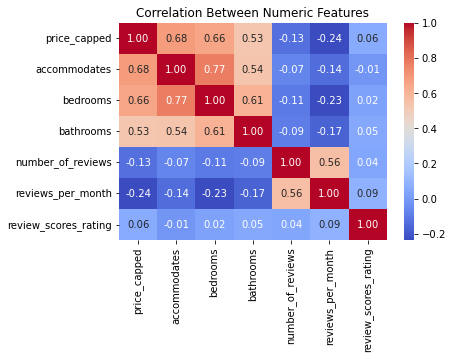

In [40]:
# Correlation matrix
numeric_cols = ['price_capped', 'accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews', 'reviews_per_month', 'review_scores_rating']
corr = listings_clean[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Numeric Features")
plt.show()


In [41]:
neigh_prices = listings_clean.groupby('neighbourhood_cleansed')['price_capped'].median().sort_values(ascending=False)
print(neigh_prices.head(10))  # Top 10 priciest neighborhoods


neighbourhood_cleansed
Briarcliff                   173.5
Pioneer Square               150.0
Westlake                     150.0
Industrial District          150.0
Southeast Magnolia           150.0
Central Business District    149.0
Belltown                     139.0
Pike-Market                  133.0
Portage Bay                  132.5
Pinehurst                    132.0
Name: price_capped, dtype: float64


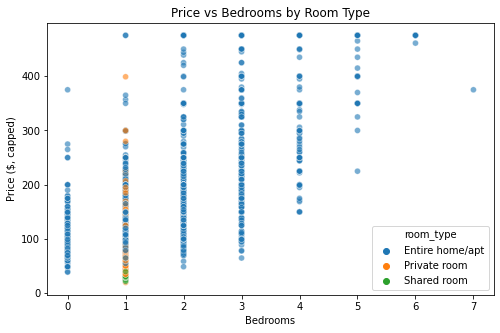

In [42]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='bedrooms', y='price_capped', hue='room_type', data=listings_clean, alpha=0.6)
plt.title("Price vs Bedrooms by Room Type")
plt.ylabel("Price ($, capped)")
plt.xlabel("Bedrooms")
plt.show()


# Regression Model

In [43]:
model_cols = [
    'price_capped',
    'accommodates',
    'bedrooms',
    'bathrooms',
    'room_type',
    'neighbourhood_cleansed'
]

df_model = listings_clean[model_cols].copy()

df_model = pd.get_dummies(
    df_model,
    columns=['room_type', 'neighbourhood_cleansed'],
    drop_first=True
)

X = df_model.drop('price_capped', axis=1)
y = df_model['price_capped']

X = sm.add_constant(X)  # adds intercept
model = sm.OLS(y, X).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_capped   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     71.52
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:28:15   Log-Likelihood:                -20141.
No. Observations:                3795   AIC:                         4.047e+04
Df Residuals:                    3703   BIC:                         4.104e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               25.5170      6.329      4.032      0.000      13.108      37.926
accommodates                                         7.9809      0.749     10.649      0.000       6.511       9.450
bedrooms                                            33.2678      1.620     20.531      0.000      30.091      36.445
bathrooms                                           24.2773      1.802     13.474      0.000      20.745      27.810
room_type_Private room                             -34.2828      2.124    -16.139      0.000     -38.447     -30.118
room_type_Shared room                              -71.9776      4.969    -14.486      0.000     -81.719     -62.236
neighbourhood_cleansed_Alki                         31.6535      9.655      3.278      0.001      12.723      50.584
neighbourhood_cleansed_Arbor Heights                 6.5334     22.885      0.285      0.775     -38.335      51.402
neighbourhood_cleansed_Atlantic                     -4.4741      9.004     -0.497      0.619     -22.127      13.179
neighbourhood_cleansed_Belltown                     38.6613      6.798      5.687      0.000      25.334      51.989
neighbourhood_cleansed_Bitter Lake                 -17.4151     14.942     -1.165      0.244     -46.711      11.881
neighbourhood_cleansed_Briarcliff                    6.2475     14.529      0.430      0.667     -22.239      34.734
neighbourhood_cleansed_Brighton                    -11.8273     14.946     -0.791      0.429     -41.130      17.475
neighbourhood_cleansed_Broadview                   -18.4995     13.375     -1.383      0.167     -44.723       7.724
neighbourhood_cleansed_Broadway                     24.6022      6.434      3.824      0.000      11.989      37.216
neighbourhood_cleansed_Bryant                       -5.9742     10.919     -0.547      0.584     -27.383      15.434
neighbourhood_cleansed_Cedar Park                   -4.8680     18.458     -0.264      0.792     -41.057      31.321
neighbourhood_cleansed_Central Business District    40.7799      7.717      5.284      0.000      25.649      55.911
neighbourhood_cleansed_Columbia City               -21.5921      8.782     -2.459      0.014     -38.810      -4.375
neighbourhood_cleansed_Crown Hill                  -27.2362     12.315     -2.212      0.027     -51.381      -3.092
neighbourhood_cleansed_Dunlap                      -11.6395     12.832     -0.907      0.364     -36.797      13.518
neighbourhood_cleansed_East Queen Anne              26.5113      8.048      3.294      0.001      10.733      42.290
neighbourhood_cleansed_Eastlake                     18.8784      9.454      1.997      0.046       0.342      37.414
neighbourhood_cleansed_Fairmount Park    

In [44]:
coef_df = pd.DataFrame({
    'feature': model.params.index,
    'coefficient': model.params.values
}).sort_values(by='coefficient', ascending=False)

coef_df.head(10)


,feature,coefficient
37,neighbourhood_cleansed_Industrial District,85.069070
65,neighbourhood_cleansed_Pioneer Square,76.348677
78,neighbourhood_cleansed_Southeast Magnolia,59.782949
88,neighbourhood_cleansed_Westlake,52.449210
80,neighbourhood_cleansed_Sunset Hill,52.062229
36,neighbourhood_cleansed_Holly Park,45.913414
63,neighbourhood_cleansed_Pike-Market,43.915778
76,neighbourhood_cleansed_South Lake Union,43.435150
17,neighbourhood_cleansed_Central Business District,40.779945
86,neighbourhood_cleansed_West Queen Anne,40.182487


In [51]:
# Remove the prefix for nicer labels
coef_df['neighborhood'] = coef_df['feature'].str.replace('neighbourhood_cleansed_', '', regex=False)

# Keep only the columns we need
coef_df = coef_df[['neighborhood', 'coefficient']]

# Sort descending by coefficient (optional)
coef_df = coef_df.sort_values(by='coefficient', ascending=False)

# Export to CSV for Tableau
coef_df.to_csv("/Users/courtney/Desktop/seattle-airbnb-analysis/data/clean/coef_df.csv", index=False)


In [52]:
coef_df

,neighborhood,coefficient
37,Industrial District,85.069070
65,Pioneer Square,76.348677
78,Southeast Magnolia,59.782949
88,Westlake,52.449210
80,Sunset Hill,52.062229
...,...,...
75,South Delridge,-30.070244
4,room_type_Private room,-34.282775
64,Pinehurst,-35.191082
77,South Park,-50.872014


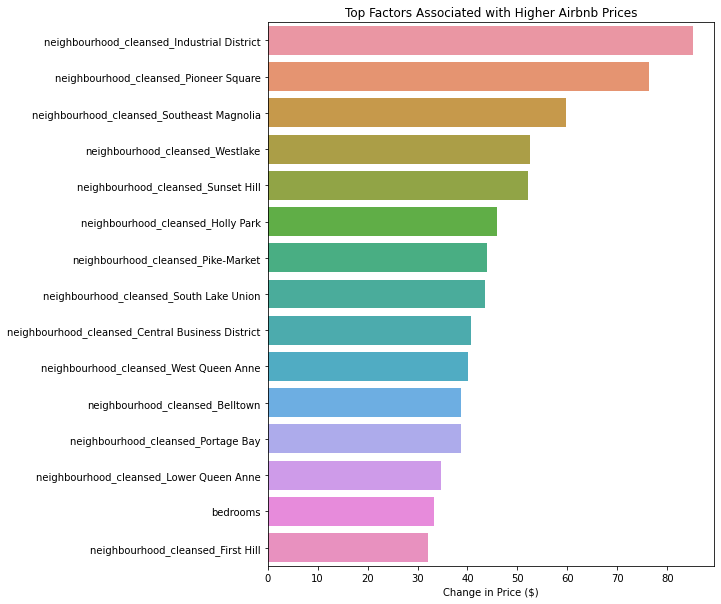

In [45]:
coef_df = coef_df[coef_df['feature'] != 'const']

plt.figure(figsize=(8,10))
sns.barplot(
    x='coefficient',
    y='feature',
    data=coef_df.sort_values(by='coefficient', ascending=False).head(15)
)
plt.title("Top Factors Associated with Higher Airbnb Prices")
plt.xlabel("Change in Price ($)")
plt.ylabel("")
plt.show()


Initial Conclusion

The exploratory analysis and regression model indicate that listing size (bedrooms, bathrooms, guest capacity) and room type are key drivers of Airbnb prices in Seattle. Initial results also suggest that location matters: several neighborhoods appear to command higher prices than others, even after controlling for listing characteristics. To provide more concrete, neighborhood-level evidence of this location effect, I next examine the regression coefficients for each neighborhood and visualize their impact using scatter plots.


In [46]:
# Listing counts (how many Airbnbs in each neighborhood)
listing_counts = (
    listings_clean
    .groupby('neighbourhood_cleansed')
    .size()
    .reset_index(name='listing_count')  # convert Series to DataFrame
    .sort_values(by='listing_count', ascending=False)
)

# Average price (capped) per neighborhood
neighborhood_summary = (
    listings_clean
    .groupby('neighbourhood_cleansed')
    .agg(
        avg_price=('price_capped', 'mean'),
        listing_count=('price_capped', 'count')
    )
    .reset_index()
    .sort_values(by='avg_price', ascending=False)
)

# Extract regression coefficients for neighborhoods
coef_neigh = coef_df[coef_df['feature'].str.startswith('neighbourhood_cleansed_')].copy()
coef_neigh['neighborhood'] = coef_neigh['feature'].str.replace('neighbourhood_cleansed_', '', regex=False)

# Merge with neighborhood_summary
neighborhood_proof = neighborhood_summary.merge(coef_neigh[['neighborhood','coefficient']], left_on='neighbourhood_cleansed', right_on='neighborhood', how='left')

# Step 4: Sort by coefficient or avg_price to see top neighborhoods
print("Top neighborhoods by regression impact on price:")
neighborhood_proof.sort_values(by='coefficient', ascending=False).head(10)

Top neighborhoods by regression impact on price:


,neighbourhood_cleansed,avg_price,listing_count,neighborhood,coefficient
6,Industrial District,173.333333,6,Industrial District,85.069070
9,Pioneer Square,169.260870,23,Pioneer Square,76.348677
1,Southeast Magnolia,199.388235,17,Southeast Magnolia,59.782949
2,Westlake,176.841176,17,Westlake,52.449210
4,Sunset Hill,176.055556,18,Sunset Hill,52.062229
20,Holly Park,147.166667,6,Holly Park,45.913414
15,Pike-Market,154.867857,28,Pike-Market,43.915778
26,South Lake Union,132.714815,27,South Lake Union,43.435150
11,Central Business District,164.178218,101,Central Business District,40.779945
5,West Queen Anne,174.706154,65,West Queen Anne,40.182487


Neighborhood-Level Analysis

Next, we combine average neighborhood prices, listing counts, and regression coefficients to empirically demonstrate which neighborhoods contribute most to higher Airbnb prices.


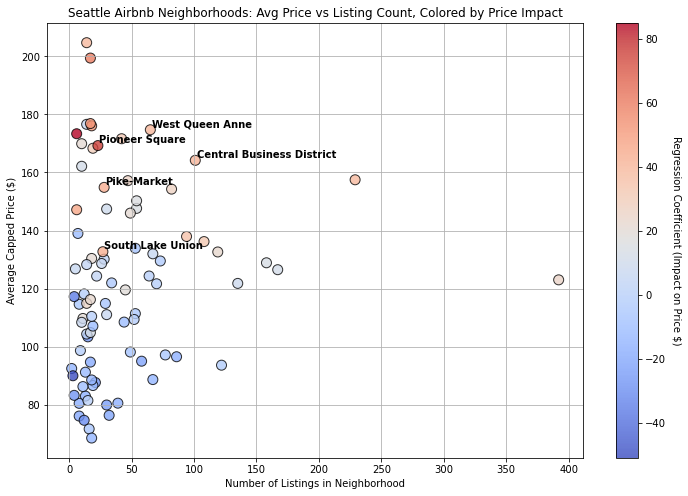

In [47]:
# Merge coefficient with the neighborhood summary table
neighborhood_summary = (
    listings_clean
    .groupby('neighbourhood_cleansed')
    .agg(
        avg_price=('price_capped', 'mean'),
        listing_count=('price_capped', 'count')
    )
    .reset_index()
)

# Merge with regression coefficients
coef_df_subset = coef_df.rename(columns={'feature':'neighborhood', 'coefficient':'coefficient'})
# Keep only neighborhood coefficients (remove 'room_type' and other dummies)
coef_df_subset = coef_df_subset[coef_df_subset['neighborhood'].str.startswith('neighbourhood_cleansed_')]
coef_df_subset['neighborhood'] = coef_df_subset['neighborhood'].str.replace('neighbourhood_cleansed_', '')

# Merge with neighborhood summary
neighborhood_summary = neighborhood_summary.merge(coef_df_subset, how='left', left_on='neighbourhood_cleansed', right_on='neighborhood')

# Fill NaN coefficients with 0 for reference neighborhood
neighborhood_summary['coefficient'] = neighborhood_summary['coefficient'].fillna(0)

# Scatter plot
plt.figure(figsize=(12,8))
scatter = plt.scatter(
    x=neighborhood_summary['listing_count'],
    y=neighborhood_summary['avg_price'],
    c=neighborhood_summary['coefficient'],
    cmap='coolwarm',
    s=100,  # point size s
    alpha=0.8,
    edgecolor='k'
)

cbar = plt.colorbar(scatter)
cbar.set_label('Regression Coefficient (Impact on Price $)', rotation=270, labelpad=15)

# Annotate top neighborhoods by coefficient AND reasonable listing count 
top_neighborhoods = neighborhood_summary[(neighborhood_summary['listing_count']>20) & (neighborhood_summary['coefficient']>40)]
for i, row in top_neighborhoods.iterrows():
    plt.text(
        row['listing_count'] + 1,  # small shift right to avoid overlapping point
        row['avg_price'] + 1,      # small shift up
        row['neighborhood'],
        fontsize=10,
        weight='bold'
    )

plt.xlabel('Number of Listings in Neighborhood')
plt.ylabel('Average Capped Price ($)')
plt.title('Seattle Airbnb Neighborhoods: Avg Price vs Listing Count, Colored by Price Impact')
plt.grid(True)
plt.show()


Conclusion

This analysis examined the factors contributing to higher Airbnb prices in Seattle using exploratory data analysis and an OLS regression model. The results show that listing size and capacity are the strongest predictors of nightly price: additional bedrooms, bathrooms, and guest capacity are all associated with statistically significant increases in price, while private and shared rooms are priced substantially lower than entire homes.

Location also plays a crucial role. Several centrally located and high-demand neighborhoods (Pioneer Square, Pike-Market, the Central Business District, South Lake Union, West Queen Anne, and Westlake) show significant price premiums relative to the reference neighborhood. Scatter plots combining average neighborhood prices, listing counts, and regression coefficients confirm that these areas consistently contribute to higher-than-average Airbnb prices.

Overall, the model explains approximately 64% of the variation in capped Airbnb prices, suggesting that both physical listing attributes and neighborhood location are key drivers of pricing in Seattle’s Airbnb market. This integrated analysis of numeric and visual evidence provides a clear, empirical demonstration of how specific neighborhoods and listing characteristics shape Airbnb pricing patterns in the city.


In [48]:
listings_clean.to_csv("/Users/courtney/Desktop/seattle-airbnb-analysis/data/clean/listings_clean.csv", index=False)